Investigating DeFi Arbitrage

In this notebook, we will demonstrate how to perform exploratory quantative analysis on DeFi data.

Our hypothesis is that there may be arbitrage opportunities between different DEX pools for the same asset pairs, due to mispricings arising from market inefficiencies. If such opportunities do exist, then in theory we could buy in one pool and sell in the other to make a profit. By executing these transactions within the same block we can realise a pure arbitrage which involves no inventory risk.

To investigate this hypothesis, we will compare pricing between the Uniswap V3 USDC-WETH 5bps pool (0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640) and the USDC-WETH 30bps pool (0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8). These are two of the highest volume, deepest liquidity pools on Ethereum. If our analysis yields promising results, we can apply the same method to other pools.

As these are both WETH-USDC pools, we expect that the prices should be tightly correlated. However, we need to take into account several factors that could cause price discrepancies (even in an efficient market), such as the fact that one pool charges a higher fee. Even if we do find price differences, to determine whether an arbitrage could be profitably realised we must perform backtests which take account of all transaction costs. At this exploratory stage, we just want to see whether the hypothesis is worth pursuing further. 

To begin, we'll plot prices from both pools for the range 17937000-17938000, as well as the price difference between the pools.

In [ ]:
pip install polars numpy matplotlib

Rows: 1911
Columns: 2
$ last_known_price_03  <f64> None, None, None, None, None, None, None, None, None, None
$ last_known_price_005 <f64> 1704.761325924081, None, None, None, None, None, None, 1704.7923469892241, None, None

None


ColumnNotFoundError: pool_address

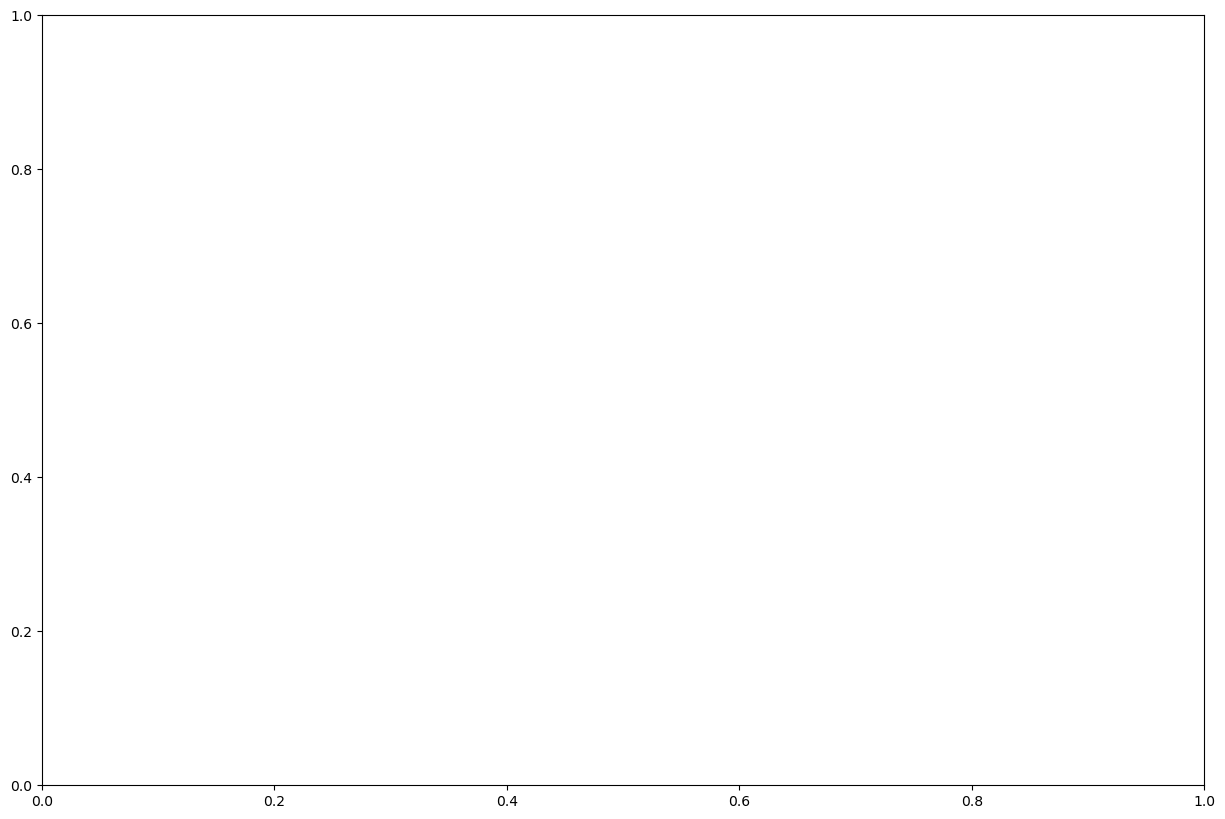

In [32]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

def load_datasets():
    return pl.scan_parquet('./data/prices_pool.parquet')

def limit_data_by_block(data, from_block, to_block):
    return data.filter((pl.col("block_number") >= from_block) & (pl.col("block_number") <= to_block))

def sort_data(data):
    return data.sort([pl.col('block_number'), pl.col('transaction_index')])

def calculate_price_differences(data):
    # Create conditional columns for each pool's price
    data = data.with_columns([
        pl.when(pl.col('pool_address') == '88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
        .then(pl.col('price'))
        .otherwise(pl.lit(None))
        .alias('last_known_price_005'),

        pl.when(pl.col('pool_address') == '8ad599c3A0ff1De082011EFDDc58f1908eb6e6D8')
        .then(pl.col('price'))
        .otherwise(pl.lit(None))
        .alias('last_known_price_03')
    ]).select([
        pl.col("last_known_price_03"),
        pl.col("last_known_price_005"),
    ])
    print(data.collect().glimpse())

    # Apply forward_fill to fill the gaps
    data = data.with_columns([
        pl.col('last_known_price_005').forward_fill().alias('filled_last_known_price_005'),
        pl.col('last_known_price_03').forward_fill().alias('filled_last_known_price_03')
    ])

    # Calculate the price differences using with_columns
    data = data.with_columns([
        (pl.col('filled_last_known_price_005') - pl.col('filled_last_known_price_03')).alias('price_difference')
    ])


    return data

def plot_data(data, from_block, to_block):
    # Create a figure and axis object
    fig, ax1 = plt.subplots(figsize=(15, 10))

    # Filter data for each pool address and plot
    pool_data_005 = data.filter(pl.col('pool_address') == '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
    ax1.plot(pool_data_005['combined_order'].to_numpy(), pool_data_005['price'].to_numpy(), linestyle='-', color="#2ca02c", linewidth=1.5, label="USDC V3 0.3%")

    pool_data_03 = data.filter(pl.col('pool_address') == '0x8ad599c3A0ff1De082011EFDDc58f1908eb6e6D8')
    ax1.plot(pool_data_03['combined_order'].to_numpy(), pool_data_03['price'].to_numpy(), linestyle='-', color="#1f77b4", linewidth=1.5, label="USDC V3 0.05%")

    # Secondary y-axis for the price difference
    ax3 = ax1.twinx()
    ax3.axhline(y=0, color='grey', linestyle='--', alpha=0.5)
    ax3.plot(data['combined_order'].to_numpy(), data['price_difference'].to_numpy(), color='#d62728', linewidth=1, linestyle='-', label='Price Difference', alpha=0.6)
    ax3.set_ylabel('Price Difference')
    ax3.tick_params(axis='y')
    ax3.legend(loc='upper right')

    # Secondary x-axis for block numbers
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())

    # Retrieve unique block numbers and create label blocks
    all_blocks = data['block_number'].unique().to_numpy()
    label_blocks = list(range(from_block, to_block + 1, 5))

    # Group by block_number and get the first combined_order for each block
    block_order_mapping_df = data.group_by('block_number').agg(pl.first('combined_order').alias('first_order'))

    # Convert the DataFrame to a dictionary with block numbers as keys and first_order as values
    block_order_dict = {row['block_number']: row['first_order'] for row in block_order_mapping_df.to_dicts()}

    # Retrieve unique block numbers and create label blocks
    all_blocks = data['block_number'].unique().to_list()
    label_blocks = list(range(from_block, to_block + 1, 5))

    # Setting x-ticks and x-tick labels
    ax2.set_xticks([block_order_dict.get(block, None) for block in all_blocks])
    ax2.set_xticklabels([str(block) if block in label_blocks and block in block_order_dict else "" for block in all_blocks], rotation=45)

    # Set labels, title, and grid for the primary y-axis
    ax1.set_xlabel('Transaction Order')
    ax1.set_ylabel('Price in USDC')
    ax1.legend(loc='upper left')

    # Set labels for the secondary x-axis
    ax2.set_xlabel('Block Number', color='gray')
    ax2.tick_params(axis='x', colors='gray')

    plt.title('USDC-WETH V3 Pools (0.05% and 0.3%) with Price Difference Overlay')
    plt.tight_layout()

    # Show the plot
    plt.show()

def main():
    from_block = 17937275
    to_block = 17937325

    data = load_datasets()
    limited_data = limit_data_by_block(data, from_block, to_block)
    combined_data_sorted = sort_data(limited_data)

    # Adjusted part for adding combined_order
    combined_data_sorted = combined_data_sorted.with_columns(
        [pl.arange(0, pl.count()).alias('combined_order')]
    )

    combined_data_sorted = calculate_price_differences(combined_data_sorted).collect()

    # print(combined_data_sorted.glimpse())
    plot_data(combined_data_sorted, from_block, to_block)

if __name__ == "__main__":
    main()